# ROOM 3: Segmentation

The purpose of this room is to learn how to handle a DICOM file for a simple Medical Segmentantion pipeline.

For this challenge, you will need to use this [folder](https://drive.google.com/drive/folders/1Oxfn67ukYZ4UzhSJglTXmoi4PMALVhRZ?usp=sharing)

Make the same procedure as in the last room, add the folder to your drive

In [ ]:
#Install Library
!pip install pydicom

In [ ]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/4.000000-HIGH RES-47.17'

For reading the image, let's use the same way as in room 2

In [ ]:
#Some functions to make the task easier
def load_dicom_series(directory):
    """Load all DICOM files from a directory and return a sorted volume."""
    slices = []
    for filename in os.listdir(directory):
        if filename.endswith(".dcm"):
            filepath = os.path.join(directory, filename)
            dicom = pydicom.dcmread(filepath)
            slices.append(dicom)
    # Sort slices by InstanceNumber or another sorting attribute
    slices.sort(key=lambda x: x.InstanceNumber)
    # Stack pixel arrays to create a 3D volume
    volume = np.stack([s.pixel_array for s in slices])
    return slices, volume

Load the folder here:

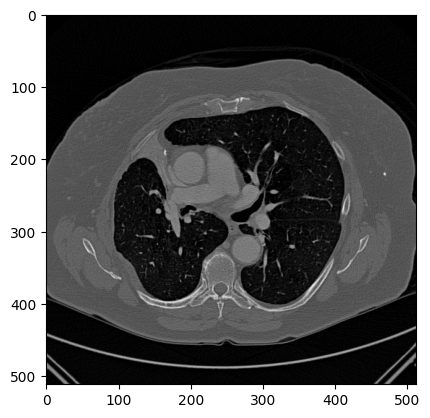

In [ ]:
#Read the image volume
slices,volume = load_dicom_series(path)

#Select the slice of interest
img = volume[120,:,:]

#Plot one slice of the image
plt.imshow(img,cmap = 'gray')

##For this room, we will segment the aorta. In this slice, it shows in 2 parts:
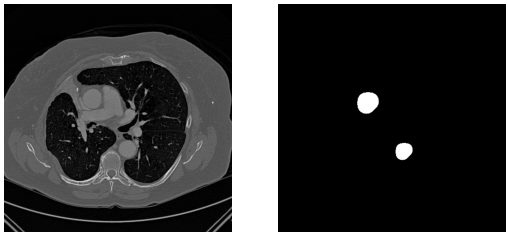

These two segments are the ones we will focus on.

###We want to segment these two segments, we will use KMeans for simplicity.

First, for better visualization, we should modify the contrast to enhance the tissue of interest.

Then, we apply a filter for removing noise and smoothing the image.

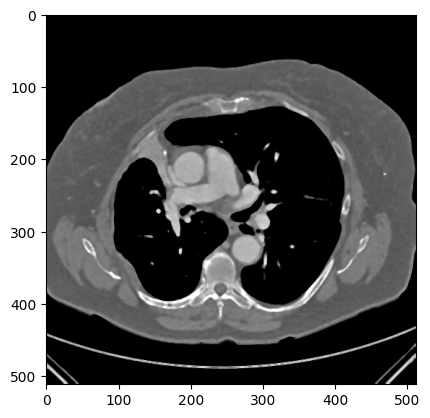

In [ ]:
img_contrast = np.clip(img, 500, 1700)
denoised = cv2.medianBlur(img_contrast, 5)
plt.imshow(denoised,cmap='gray')

This is the kmeans function that you should use:

This will return you a tuple with the clustered image and an array with the separated clusters.



In [ ]:
def apply_kmeans(image, K):
    """
    Apply K-means clustering to an image.

    Args:
        image: 2D numpy array (grayscale image).
        K: Number of clusters.

    Returns:
        masks: An array with all the masks of every cluster
        clustered_image: Image with clustered values.
    """
    # Flatten the image for K-means input
    pixels = image.flatten().astype(np.float32)

    # Define criteria for K-means (10 iterations or 1.0 accuracy)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)

    # Apply K-means clustering
    _, labels, centers = cv2.kmeans(
        pixels, K, None, criteria, 10, cv2.KMEANS_PP_CENTERS
    )

    # Convert back to image format
    clustered_image = centers[labels.flatten()]
    clustered_image = clustered_image.reshape(image.shape)

    labels = labels.flatten().reshape((image.shape[:2]))
    masks = []
    for cluster_idx in range(K):
      mask = (labels == cluster_idx).astype(np.uint8) * 255 # 65535  # Binary mask as uint16 (0 or 65535)
      masks.append(mask)

    return clustered_image.astype(np.uint16), masks

Apply the Kmeans to your denoised image, you should find in which cluster the tissue of interest is located.

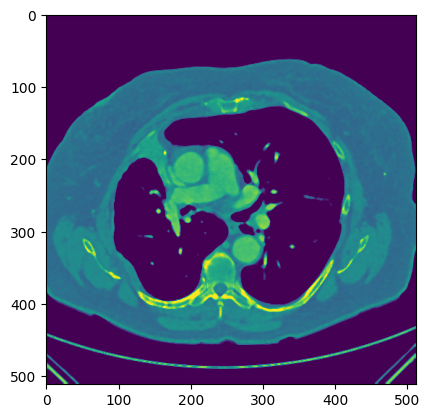

In [ ]:
clust_img , masks= apply_kmeans(denoised,5)
plt.imshow(denoised,cmap=None)

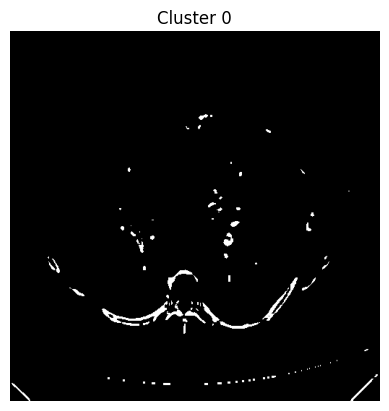

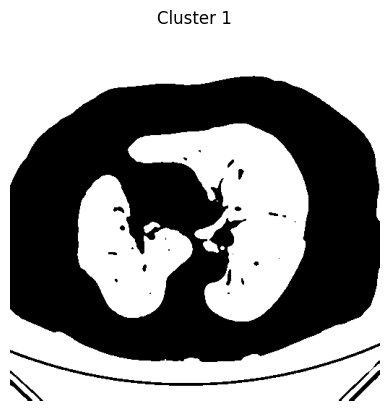

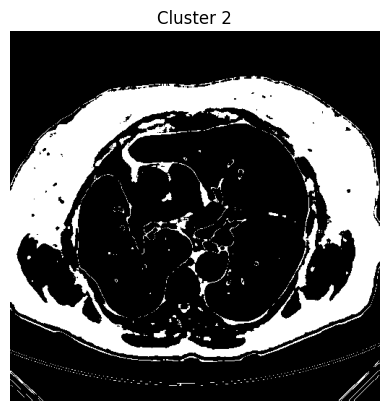

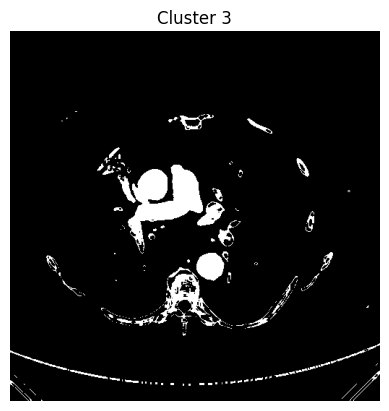

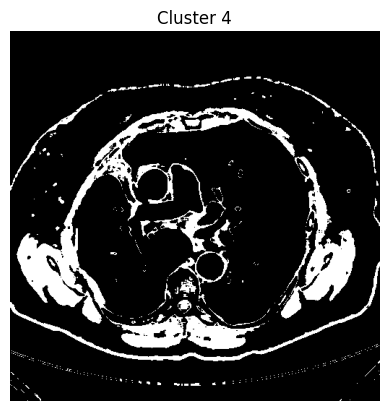

In [ ]:
#Plotting all the masks
for i, mask in enumerate(masks):
    plt.figure()
    plt.imshow(mask, cmap='gray')
    plt.title(f"Cluster {i}")
    plt.axis("off")
    plt.show()

If you take a close look to the mask, you should be able to see that the aorta is not fully separated from other structures.

In order to solve this, erode the selected mask until the regions are not connected.

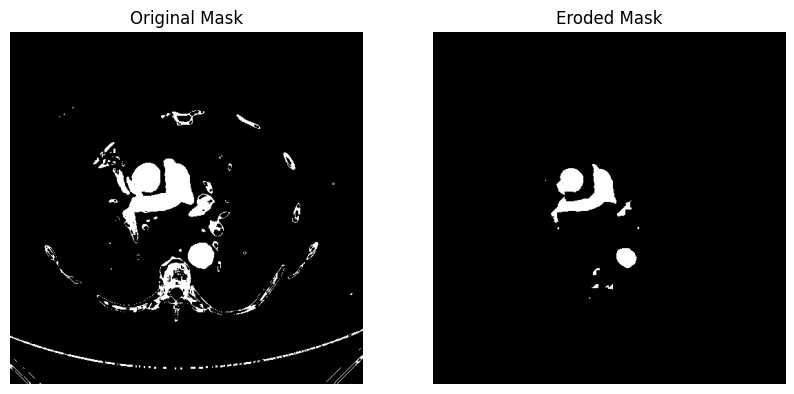

In [ ]:
#Select the cluster's mask that has the aorta tissue
mask = masks[3]
cv2.getFontScaleFromHeight
#Erode to separate components in the mask
#Use a circular kernel
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))

eroded_mask = cv2.erode(mask, kernel, iterations=8)

# Visualize the original and eroded mask
plt.figure(figsize=(10, 5))

# Original mask
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.title("Original Mask")
plt.axis("off")

# Eroded mask
plt.subplot(1, 2, 2)
plt.imshow(eroded_mask, cmap='gray')
plt.title("Eroded Mask")
plt.axis("off")

plt.show()

Now that you have the regions separated, we should just keep the aorta sections.

These two regions are the only two circular, lets use circularity to detect them.

$ Circularity = \frac{4\pi * Area}{Perimeter^2} $

In [ ]:
import cv2
import numpy as np

def get_circular_regions(eroded_mask):
    """
    Process a mask to find circular regions and return the mask.

    Args:
        eroded_mask (np.ndarray): Input binary mask.

    Returns:
        final_mask (np.ndarray): Processed mask highlighting circular regions.
    """
    # Find contours
    contours, _ = cv2.findContours(eroded_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # List to store circular contours
    circular_contours = []
    output = np.zeros_like(eroded_mask)  # Initialize an empty mask

    # Loop through contours to find circular ones
    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        if perimeter > 0:
            circularity = 4 * np.pi * (area / (perimeter ** 2))
            if 0.7 < circularity <= 1:  # Adjust threshold as needed
                circular_contours.append(contour)

    # Draw circular contours on the output mask
    cv2.drawContours(output, circular_contours, -1, (255, 255, 255), thickness=cv2.FILLED)

    return output


Now that you have detected the circular regions, dilate them back to their original size.

Hint: Use the same kernel as before

In [ ]:
output = get_circular_regions(eroded_mask)

final_mask = cv2.dilate(output, kernel, iterations=8)

Show the results.

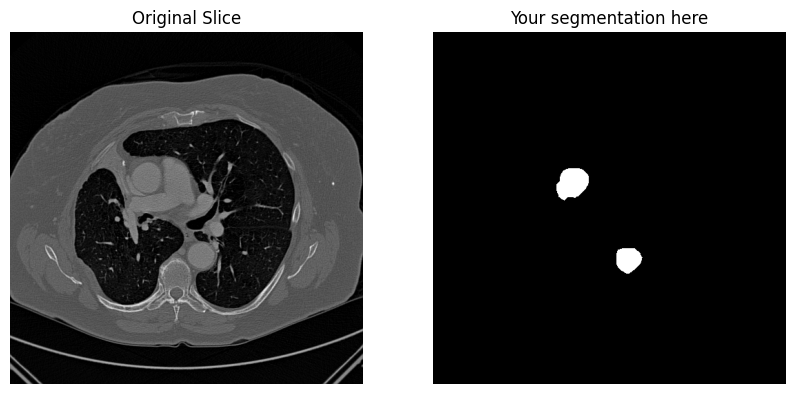

In [ ]:
# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Slice")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(final_mask, cmap='gray')
plt.title("Your segmentation here")
plt.axis("off")
plt.show()

This is the Ground Truth for the segmented aorta. Compare it with your results and get the Dice Score

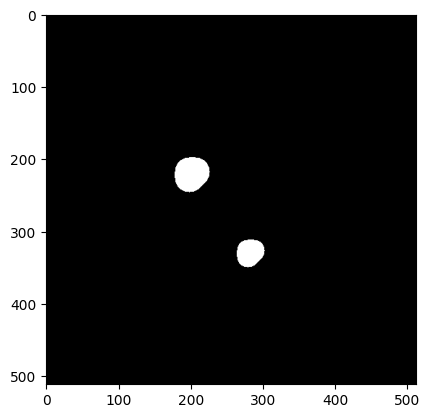

In [ ]:
gt_path = path + '/GroundTruth.png'
gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(gt,cmap='gray')

In [ ]:
def calculate_dice_score(mask1, mask2):
    """
    Calculate the Dice Similarity Coefficient (DSC) between two binary masks.

    Args:
        mask1: First binary mask as a NumPy array.
        mask2: Second binary mask as a NumPy array (ground truth).

    Returns:
        dice_score: Dice similarity coefficient (float).
    """
    # Ensure masks are binary (0 or 1)
    mask1 = (mask1 > 0).astype(np.uint8)
    mask2 = (mask2 > 0).astype(np.uint8)

    # Calculate intersection and union
    intersection = np.sum(mask1 * mask2)
    size1 = np.sum(mask1)
    size2 = np.sum(mask2)

    # Avoid division by zero
    if size1 + size2 == 0:
        return 1.0 if intersection == 0 else 0.0

    # Compute Dice Score
    dice_score = (2.0 * intersection) / (size1 + size2)
    return dice_score

In [ ]:
# Calculate Dice Score
dice = calculate_dice_score(gt, final_mask)
print(f"Dice Similarity Coefficient: {dice:.5f}")

Dice Similarity Coefficient: 0.92305


##**Congrats!!!**

You made it to the end of this challenge. Now you are an expert handling DICOM files !!!